<a href="https://colab.research.google.com/github/Gab2697/Human-Activity-Recognition/blob/master/Tsai_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TimeSeries AI

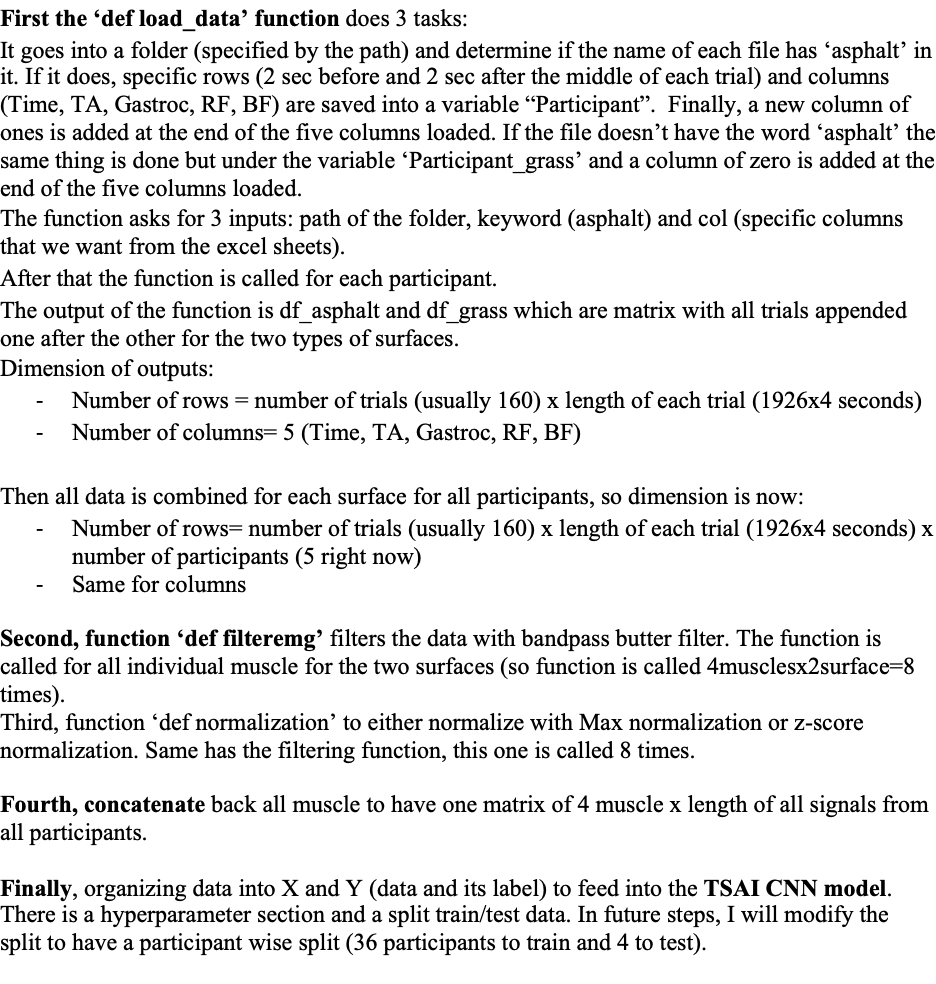

Install

In [1]:
pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.9.0 requires statsmodels<=0.12.1, but you have statsmodels 0.13.1 which is incompatible.


In [2]:
pip install scipy>=1.5


In [3]:
!pip install tsai

     |████████████████████████████████| 9.5 MB 4.3 MB/s 


Import librairies

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
from google.colab import drive 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from tsai.all import *

Give access to doc in drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip file with participant

In [ ]:
#only do once
!unzip "/content/drive/MyDrive/Gab/exported-emg-1.zip" -d "/content/drive/MyDrive/Gab/P01"
!unzip "/content/drive/MyDrive/Gab/exported-emg-3.zip" -d "/content/drive/MyDrive/Gab/P03"
!unzip "/content/drive/MyDrive/Gab/exported-emg-5.zip" -d "/content/drive/MyDrive/Gab/P05"
!unzip "/content/drive/MyDrive/Gab/exported-emg-7.zip" -d "/content/drive/MyDrive/Gab/P07"
!unzip "/content/drive/MyDrive/Gab/exported-emg-9.zip" -d "/content/drive/MyDrive/Gab/P09"

#Preprocessing

Load and cut data, create label depending on the name of the file

In [6]:
def load_data(path,keyword,col):

  Window=1926*2 
  df_asphalt = pd.DataFrame()
  df_grass = pd.DataFrame()
  for fname in os.listdir(path):
    if keyword in fname: 
      os.chdir(path)
      pd_xl_file = pd.ExcelFile(fname)
      df = pd_xl_file.parse("Sheet1") 
      dimensions = df.shape
      Middle=int(dimensions[0]/2)
      Participant=pd.read_excel(fname,sheet_name='Sheet1',  usecols = col)
      Participant['label'] = pd.DataFrame(np.ones(dimensions[0]),dtype=int)
      Participant=Participant.iloc[Middle-Window:Middle+Window]
      df_asphalt = df_asphalt.append(Participant)

    else:
      os.chdir(path)
      pd_xl_file_grass = pd.ExcelFile(fname)
      df2 = pd_xl_file_grass.parse("Sheet1") 
      dimensions_grass = df2.shape
      Middle_grass=int(dimensions_grass[0]/2)
      Participant_grass=pd.read_excel(fname,sheet_name='Sheet1', usecols = col)
      Participant_grass['label'] = pd.DataFrame(np.zeros(dimensions_grass[0]),dtype=int)
      Participant_grass=Participant_grass.iloc[Middle_grass-Window:Middle_grass+Window]
      df_grass = df_grass.append(Participant_grass)
      
  return df_asphalt, df_grass


In [7]:
#P01
path1= '/content/drive/MyDrive/Gab/P01/exported-1/'
df_asphalt_1, df_grass_1= load_data(path1,'sidewalk',"A,B,J,R,Z")
#P03
path3= '/content/drive/MyDrive/Gab/P03/exported-emg/'
df_asphalt_3, df_grass_3= load_data(path3,'asphalt',"A,B,D,L,T")
#P05
path5= '/content/drive/MyDrive/Gab/P05/exported-emg-5/'
df_asphalt_5, df_grass_5= load_data(path5,'asphalt',"A,B,D,L,T")
#P07
path7= '/content/drive/MyDrive/Gab/P07/exported-emg-7/'
df_asphalt_7, df_grass_7= load_data(path7,'asphalt',"A,B,D,L,T")
#P09
path9= '/content/drive/MyDrive/Gab/P09/exported-emg-9/'
df_asphalt_9, df_grass_9= load_data(path9,'asphalt',"A,B,D,L,T")

# while True:pass

In [8]:
df_asphalt_3

,X [s],Trigno sensor 1-TA: EMG 1 [Volts],Trigno sensor 2-Gastroc: EMG 2 [Volts],Trigno sensor 3-RF: EMG 3 [Volts],Trigno sensor 4-BF: EMG 4 [Volts],label
5768,2.994923,2.517739e-06,-4.196231e-06,1.678492e-07,0.000000,1
5769,2.995442,1.846342e-06,3.189136e-06,-1.678492e-07,0.000000,1
5770,2.995962,1.510643e-06,4.196231e-06,1.510643e-06,0.000000,1
5771,2.996481,6.713969e-07,2.517739e-06,1.846342e-06,0.000000,1
5772,2.997000,1.510643e-06,5.035477e-07,2.517739e-06,0.000000,1
...,...,...,...,...,...,...
11543,5.993481,-2.601663e-05,1.678492e-06,7.721065e-06,0.000096,1
11544,5.994000,-2.568093e-05,8.560311e-06,7.553216e-06,0.000050,1
11545,5.994519,-2.500954e-05,-8.392462e-07,5.874723e-06,-0.000016,1
11546,5.995038,-2.517739e-05,-1.661708e-05,5.539025e-06,-0.000085,1


In [9]:
#COMBINE ALL PARTICIPANTS
df_grass=(((df_grass_1.append(df_grass_3)).append(df_grass_5)).append(df_grass_7)).append(df_grass_9)
df_asphalt=(((df_asphalt_1.append(df_asphalt_3)).append(df_asphalt_5)).append(df_asphalt_7)).append(df_asphalt_9)

In [11]:
df_asphalt

,X [s],Trigno sensor 1-TA: EMG 1 [Volts],Trigno sensor 2-Gastroc: EMG 2 [Volts],Trigno sensor 3-RF: EMG 3 [Volts],Trigno sensor 4-BF: EMG 4 [Volts],label
7211,3.744173,0.000015,0.000000,0.000016,0.000000,1
7212,3.744692,0.000007,0.000000,0.000015,0.000000,1
7213,3.745212,-0.000009,0.000000,0.000013,0.000000,1
7214,3.745731,-0.000020,0.000000,0.000015,0.000000,1
7215,3.746250,-0.000024,0.000000,0.000019,0.000000,1
...,...,...,...,...,...,...
11543,5.993481,-0.000027,-0.000225,-0.000008,0.000007,1
11544,5.994000,0.000022,-0.000235,-0.000007,0.000006,1
11545,5.994519,0.000076,-0.000260,-0.000006,0.000006,1
11546,5.995038,0.000142,-0.000296,-0.000004,0.000007,1


Filtering of EMG

In [ ]:
def filteremg(time, emg, Fs=1926, high_band=20, low_band=500):
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(Fs/2)
    low_band = low_band/(Fs/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    

    return emg_filtered

In [ ]:
#call filtering function for all muscles/surfaces
df_grass_TA=filteremg(df_grass.iloc[:,0], df_grass.iloc[:,1])
df_grass_G=filteremg(df_grass.iloc[:,0], df_grass.iloc[:,2])
df_grass_RF=filteremg(df_grass.iloc[:,0], df_grass.iloc[:,3])
df_grass_BF=filteremg(df_grass.iloc[:,0], df_grass.iloc[:,4])
df_asphalt_TA=filteremg(df_asphalt.iloc[:,0], df_asphalt.iloc[:,1])
df_asphalt_G=filteremg(df_asphalt.iloc[:,0], df_asphalt.iloc[:,2])
df_asphalt_RF=filteremg(df_asphalt.iloc[:,0], df_asphalt.iloc[:,3])
df_asphalt_BF=filteremg(df_asphalt.iloc[:,0], df_asphalt.iloc[:,4])

Normalization ---this is done with all trial combine, might be better to be do indiv.

In [ ]:
#max normal for [0,1] interval
def normalization(emg):
    max_data=max(emg)
    min_data=min(emg)
#itterer pour chaque column 
    emg_df = pd.DataFrame(emg)
    emg_normalized_all=[]
    for i in range(0,len(emg_df)):
      EMG_normalized=(emg_df.iloc[i]-min_data)/(max_data-min_data)
      emg_normalized_all.append(EMG_normalized)# adding the element to the array

    return emg_normalized_all
"""
#z-score normalization
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

TA_normalized=feature_normalize(TA_filt)
plt.plot(TA_normalized)
"""

'\n#z-score normalization\ndef feature_normalize(dataset):\n    mu = np.mean(dataset,axis = 0)\n    sigma = np.std(dataset,axis = 0)\n    return (dataset - mu)/sigma\n\nTA_normalized=feature_normalize(TA_filt)\nplt.plot(TA_normalized)\n'

In [ ]:
#normalize each muscles /surfaces 
df_grass_TA=pd.DataFrame(normalization(df_grass_TA))
df_grass_G=pd.DataFrame(normalization(df_grass_G))
df_grass_RF=pd.DataFrame(normalization(df_grass_RF))
df_grass_BF=pd.DataFrame(normalization(df_grass_BF))
df_asphalt_TA=pd.DataFrame(normalization(df_asphalt_TA))
df_asphalt_G=pd.DataFrame(normalization(df_asphalt_G))
df_asphalt_RF=pd.DataFrame(normalization(df_asphalt_RF))
df_asphalt_BF=pd.DataFrame(normalization(df_asphalt_BF))

In [ ]:
#concatenate back all grass into one variable and all asphalt into one variable
df_grass_all=[df_grass_TA,df_grass_G,df_grass_RF,df_grass_BF]
df_grass_all=pd.concat(df_grass_all,axis=1)

df_asphalt_all=[df_asphalt_TA,df_asphalt_G,df_asphalt_RF,df_asphalt_BF]
df_asphalt_all=pd.concat(df_asphalt_all,axis=1)


df_grass=df_grass_all
df_asphalt=df_asphalt_all

Organize corectly into X,y

In [19]:
#concatenate both tasks
df_asphalt=df_asphalt.iloc[1: , :]
df_grass=df_grass.iloc[1: , :]
All=df_asphalt.append(df_grass) 

#remove time
All = pd.DataFrame(All.iloc[: , 1:])

# assign X,y
y = All.iloc[:,4]#assign label 
X = All.iloc[:,0:4] 

X

,Trigno sensor 1-TA: EMG 1 [Volts],Trigno sensor 2-Gastroc: EMG 2 [Volts],Trigno sensor 3-RF: EMG 3 [Volts],Trigno sensor 4-BF: EMG 4 [Volts]
7213,-0.000009,0.000000,0.000013,0.0
7214,-0.000020,0.000000,0.000015,0.0
7215,-0.000024,0.000000,0.000019,0.0
7216,-0.000019,0.000000,0.000023,0.0
7217,-0.000014,0.000000,0.000023,0.0
...,...,...,...,...
12986,0.000000,0.003404,0.000000,0.0
12987,0.000000,0.003945,0.000000,0.0
12988,0.000000,0.004114,0.000000,0.0
12989,0.000000,0.004082,0.000000,0.0


In [20]:
#Standardize features by removing the mean and scaling to unit variance--z = (x - u) / s
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(data = X, columns=['TA','Gastroc','RF','BF'])
X['Label'] = y.values
print(X)

               TA   Gastroc        RF        BF  Label
0       -0.001077  0.003105  0.072580 -0.000378      1
1       -0.015586  0.003105  0.080682 -0.000378      1
2       -0.020783  0.003105  0.109039 -0.000378      1
3       -0.014936  0.003105  0.131319 -0.000378      1
4       -0.008006  0.003105  0.131319 -0.000378      1
...           ...       ...       ...       ...    ...
5269527  0.009967  6.028858 -0.007428 -0.000378      0
5269528  0.009967  6.986846 -0.007428 -0.000378      0
5269529  0.009967  7.286366 -0.007428 -0.000378      0
5269530  0.009967  7.229314 -0.007428 -0.000378      0
5269531  0.009967  7.295874 -0.007428 -0.000378      0

[5269532 rows x 5 columns]


Model hyperparameter 

In [21]:
window_length = 1926*4  # trial length
stride = None                # None =no overlap
start = 0                    # use all data since the first time stamp (default = 0)
get_x = X.columns[0:4]     # Indicates which are the columns that contain the x data.
get_y = 'Label'             # In multivariate time series, you must indicate which is/are the y columns
horizon = 0                  # 0 means y is taken from the last time stamp of the time sequence (default = 0)
seq_first = True
                            
print(get_x,get_y)

Index(['TA', 'Gastroc', 'RF', 'BF'], dtype='object') Label


Split train and test data

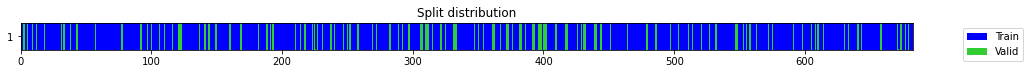

(#683) [(TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1)), (TSTensor(vars:4, len:7704, device=cpu), TensorCategory(1))] ...]

In [22]:
X, y = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x,  get_y=get_y, horizon=horizon, seq_first=seq_first)(X)
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dsets

CNN model and vizualisation

In [ ]:
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-3)##epoch=5 avec 5 participants (RAM crashed)---epoch=15 (28min)avec 1 participant-- 25 epoch avec 1 participant=54min  
learn.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.show_probas()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()